# **DSCI100 Project: Predicting Playtime Range from Age and Experience**

#### Group 42
#### Members: Linda Zhu, Eunelsy Trillanes, Lavender Sun, and Kelly Ye

## **Introduction**

*Based on a player's age and experience, can we predict the range of hours — zero, low, medium, high, or extreme — that they will contribute?*

**Instructions:** 
* provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
* clearly state the question you tried to answer with your project
* identify and fully describe the dataset that was used to answer the question

### Background
A Computer Science research group at UBC is studying how people interact with and play video games. Their study uses a Minecraft server called PLAICRAFT, which is a virtual open-world game where players can explore, build, and interact freely. As players engage in this environment, the server records data about their in-game behaviours. This data provides insights into gaming habits, player engagement, and interaction patterns.

However, managing such a server isn’t easy. The research team posed three key questions to guide their study of player behaviour on the Minecraft server:

1. Which types of players are most likely to contribute a large amount of data?
2. What time windows are most likely to have a large number of simultaneous players? 
3. Can a player’s likelihood of continued participation be predicted based on their past participation? 

### Our question

For this project, we have chosen to focus on the first question: identifying the kinds of players most likely to contribute a large amount of data, i.e. will play the most hours on PLAICRAFT. This question aligns with the goal of optimizing recruitment efforts to maximize the quality and quantity of data collected, and will help narrow down which types of players to target based on their characteristics.

To explore this question, we narrowed down the first question even more. We chose to see if a player’s age and self-proclaimed experience (beginner, amateur, regular, pro, or veteran) affected their play time. Can identify groups of players with certain ages and experiences that will lead to higher play times? These considerations led us to a new question: 

Which age and experience of players should be targeted to maximize played hours?

### The dataset

We chose to use the `players.csv` data set to answer our question, specifically the `experience` and `age` variables. The `players.csv` dataset includes data from 196 players and 9 variables. 

Below is a chart of the variables in the `players.csv` dataset, the type of variable it is, and its explanation: 

|#| Variable | Type | Explanation |
|:----:|:--------:|:--------:|:--------:|
|1|experience|character|Categories of the experience level of the players. How the players themselves would rate their expertise in playing the game, with 5 categories: Pro, Veteran, Amateur, Regular, and Beginner|
|2|subscribe|logical|Tells if the player is subscribed to PLAICRAFT's emails or not|
|3|hashedEmail|character|Encrypted email of the player|
|4|played_hours|double|Number of hours that the player has played the game so far|
|5|name|character|The player's name|
|6|gender|character|The player's gender|
|7|age|double|The player's age|
|8|individualId|logical|The player's age|
|9|organizationName|logical|The player's organization name|

## **Methods and Results**

**Instructions:** describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all figures should have a figure number and a legend

In [2]:
# Loading the necessary packages to read and process the data:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# Reading the data from a URL. Data is in .csv format, so read_csv is used.
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
player_data <- read_csv(url) |>
        # Selecting only the relevant variables to reduce the dataset size
        select(experience, played_hours, age) 

head(player_data) # Preview the data!

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,age
<chr>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
Amateur,0.7,21
Regular,0.1,21
Amateur,0.0,17


Below is the code used to wrangle the data. As we want to convert played_hours into a categorical variable, we created five subsets with the following ranges to categorize observations into the classes Zero, Low, Medium, High, or Extreme. The ranges were chosen to ensure approximately equal distribution of datapoints to each class to avoid class imbalance. The subsets were then combined using the rbind() function.

In [4]:

zero <- player_data |>
        filter(played_hours == 0) |>
        mutate(hours_range = "Zero")

low <- player_data |>
        filter(played_hours > 0 , played_hours <= 0.25) |>
        mutate(hours_range = "Low")

medium <- player_data |>
        filter(played_hours > 0.25 , played_hours <= 1) |>
        mutate(hours_range = "Medium")

high <- player_data |>
        filter(played_hours > 1, played_hours <= 5) |>
        mutate(hours_range = "High")

extreme <- player_data |>
        filter(played_hours > 5) |>
        mutate(hours_range = "Extreme")

# Combining into one dataframe:

player_data_classes <- rbind(zero, low, medium, high, extreme) 

Next, we also want to convert experience level into a numerical variable by assigning values to each. Assuming experience level increases in the order amateur<beginner<regular<pro<veteran, five data subsets were created and values of 0-4 were assigned in a new column called exp_level. The final dataset is named final_data.

In [5]:
amateur <- player_data_classes |>
        filter(experience == "Amateur") |>
        mutate(exp_level = 0)

beginner <- player_data_classes |>
        filter(experience == "Beginner") |>
        mutate(exp_level = 1)

regular <- player_data_classes |>
        filter(experience == "Regular") |>
        mutate(exp_level = 2)

pro <- player_data_classes |>
        filter(experience == "Pro") |>
        mutate(exp_level = 3)

veteran <- player_data_classes |>
        filter(experience == "Veteran") |>
        mutate(exp_level = 4)

final_data <- rbind(amateur, beginner, regular, pro, veteran) |>
                    select(age, hours_range, exp_level) |>
                    mutate(hours_range = as_factor(hours_range))

head(final_data) # Previewing the data


age,hours_range,exp_level
<dbl>,<fct>,<dbl>
17,Zero,0
21,Zero,0
22,Zero,0
17,Zero,0
33,Zero,0
17,Zero,0


Next, we can start training our model. First, we should split the data into a training and testing set, and work with the training set first.

In [6]:
set.seed(202442)
data_split <- initial_split(final_data, prop = 0.75, strata = hours_range)
data_training <- training(data_split)
data_testing <- testing(data_split)

We can probe to see if there are any obvious trends in the data through a preliminary plot, as below. It seems that there is no obvious trend here.

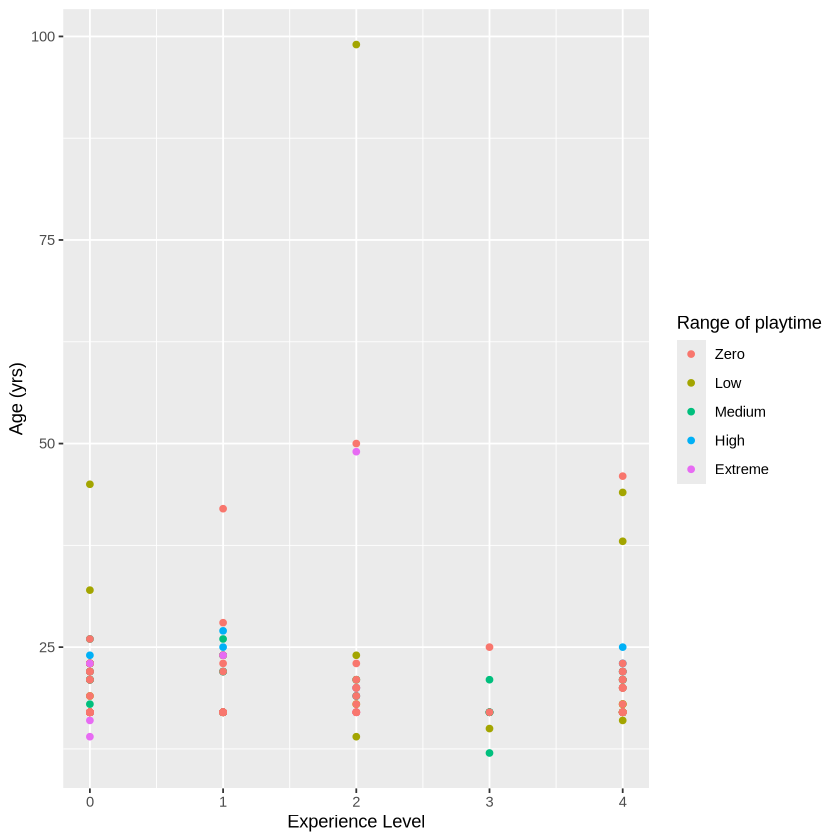

In [7]:
initial_plot <- data_training |>
            ggplot(aes(x=exp_level, y=age, color=hours_range)) +
            geom_point() +
            labs(x="Experience Level", y="Age (yrs)", color="Range of playtime")
initial_plot

Moving on, we can create the model as such. We decided upon a 75% training:testing split as well as a 5-fold cross validation as we have done in class.

In [8]:
player_recipe <- recipe(hours_range ~ age + exp_level, data= data_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

kvals <- tibble(neighbors = seq(from=1, to=50, by=4))
player_vfold <- vfold_cv(data_training, v=5, strata = hours_range)

player_results <- workflow() |>
            add_recipe(player_recipe) |>
            add_model(player_model) |>
            tune_grid(resamples = player_vfold, grid = kvals) |>
            collect_metrics() 
            
player_accuracy <- player_results |>
            select(neighbors, .metric, mean) |>
            filter(.metric == "accuracy") |>
            arrange(-mean) 

player_accuracy


neighbors,.metric,mean
<dbl>,<chr>,<dbl>
29,accuracy,0.4326181
33,accuracy,0.4323883
37,accuracy,0.4323883
41,accuracy,0.4323883
45,accuracy,0.4323883
49,accuracy,0.4323883
25,accuracy,0.4123883
21,accuracy,0.3985441
17,accuracy,0.3763218


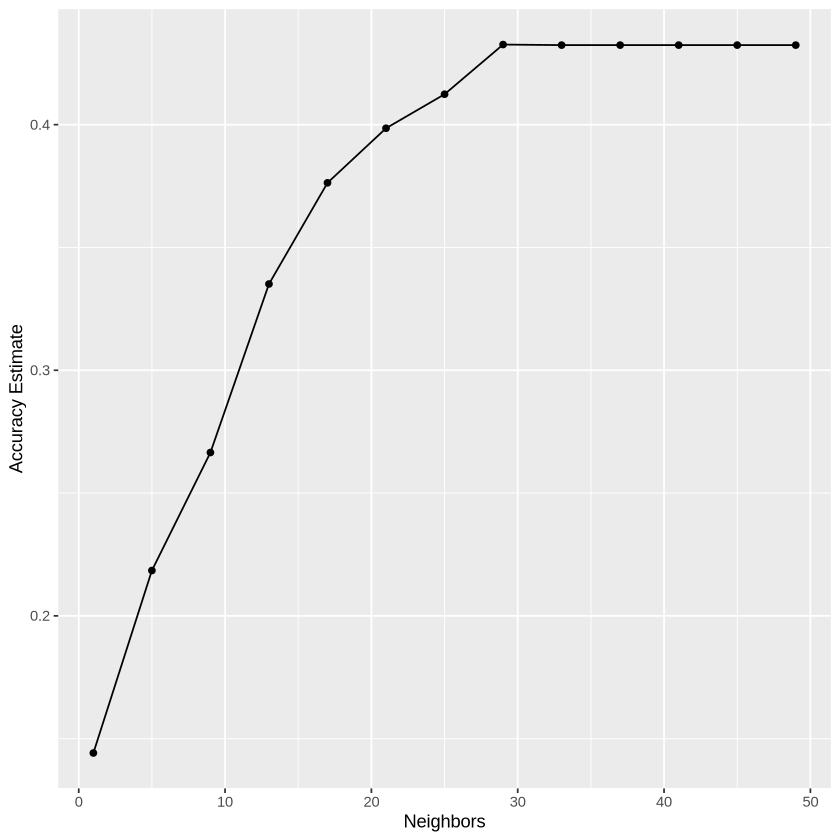

In [9]:
cross_val_plot <- player_accuracy |>
            ggplot(aes(x=neighbors, y=mean))+
            geom_point()+
            geom_line()+
            labs(x = "Neighbors", y = "Accuracy Estimate") 

cross_val_plot

It appears that the accuracy maxes out around 33 (though note that the means are still estimates so the actual best k value might be different!). This is the value we will choose to retrain our model.

In [10]:
player_model_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
            set_engine("kknn") |>
            set_mode("classification")

player_fit <- workflow() |>
        add_recipe(player_recipe) |>
        add_model(player_model_k) |>
        fit(data = data_training)

Now for the evaluation of accuracy based on the training set:

In [11]:
player_predictions <- predict(player_fit, data_testing)|>
                bind_cols(data_testing)

model_accuracy <- player_predictions |>
        metrics(truth = hours_range, estimate = .pred_class)|>
          filter(.metric == "accuracy") |>
          select(.estimate) |>
          pull()

print(paste(model_accuracy, "is the model's accuracy.")) 


[1] "0.44 is the model's accuracy."


Let's test the model on a new observation, to see if it works!

In [12]:
new_player <- tibble(age = 12, exp_level = 3)

player_predict <- predict(player_fit, new_player)
player_predict

.pred_class
<fct>
Zero


Now, to characterize which groups of people will give the highest play times, we will create new, fake datasets to test our model on. By running our data on these "fabricated" data sets, we will be able to gauge the combined characteristics of the players who will give high play times. We made a Google Sheets to make our fake data, and imported the file to this Jupyter Notebook. 

In [18]:
# Loading in the fake players data set

url <- "https://drive.google.com/uc?export=download&id=177BnvAy2DI-YJAGaoQucoAz0TQmxRZ6H"
fake_player_data <- read.csv(url)


# Filtering for experience level

fake_amateur<- fake_player_data |>
                filter(exp_level=='amateur')|>
                mutate(exp_level = 0)

fake_beginner<- fake_player_data|>
                filter(exp_level=='beginner')|>
                mutate(exp_level = 1)

fake_regular<- fake_player_data|>
                filter(exp_level=='regular')|>
                mutate(exp_level = 2)

fake_pro<- fake_player_data |>
            filter(exp_level=='pro')|>
                mutate(exp_level = 3)

fake_veteran <- fake_player_data |>
                filter(exp_level=='veteran')|>
                mutate(exp_level = 4)

fake_players <- rbind(fake_amateur, fake_beginner, fake_regular, fake_pro, fake_veteran) 

# Show the head and tail of our fake dataset for clarity

head(fake_players)
tail(fake_players)

,exp_level,age
,<dbl>,<int>
1,0,0
2,0,1
3,0,2
4,0,3
5,0,4
6,0,5


,exp_level,age
,<dbl>,<int>
500,4,95
501,4,96
502,4,97
503,4,98
504,4,99
505,4,100


In the above dataset, we made it so that there is one observation with their age ranging from 1-100 for all 4 of the experience levels. This way, after we run the model on this dataset, the output will tell us the predicted class of playtime hours (zero, low, medium, high, or extreme) for each age and experience level. If we know the class of playtime hours, we we then be able to pinpoint which experience and age combination will yield the highest play times.  

Below, we use our fake dataset to predict the classes of playtime hours and graph the results.

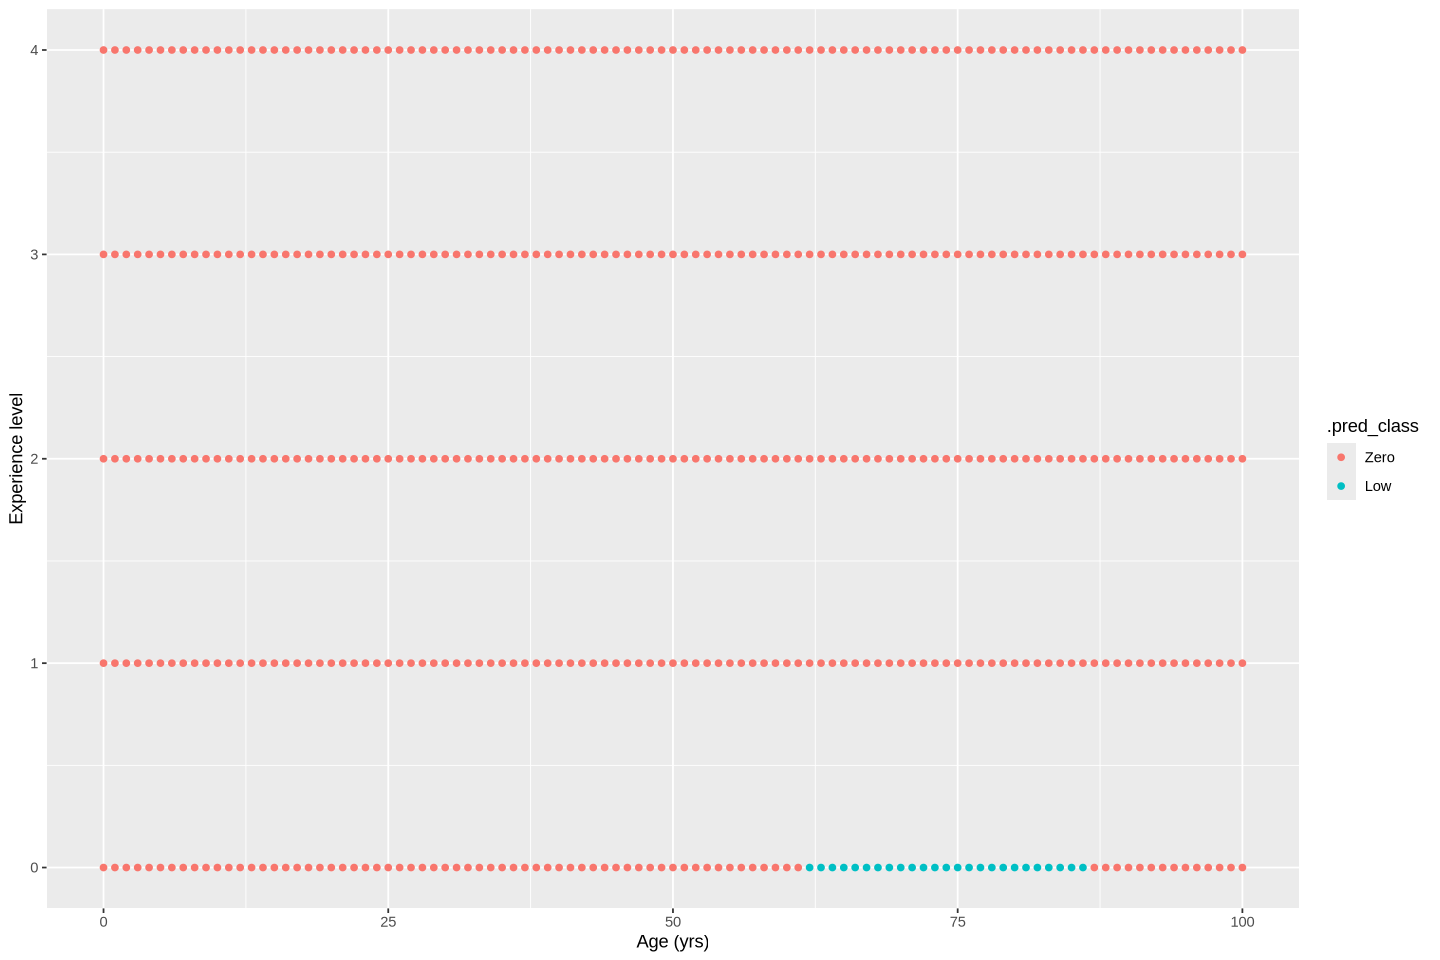

In [14]:
# Using the fake_players dataset to predict the classes of playtime hours. We can also graph the results!

fake_player_predictions <- predict(player_fit, fake_players)|>
                bind_cols(fake_players)

options(repr.plot.width=12, repr.plot.height=8)
fake_player_plot <- fake_player_predictions |>
                ggplot(aes(x=age, y=exp_level, color = .pred_class)) +
                geom_point() +
                labs(x="Age (yrs)", y= "Experience level")
fake_player_plot

Using the above KNN classifier model, with 17 neighbors, there were a limited number of Medium playtime predictions and no High or Extreme predictions. Although this would decrease the accuracy, we can try to set k to a lower value to avoid potential overfitting. 
Here is code for an alternate model with a lower k - for example, k=9 (which would give accuracy of ~0.3 as calculated above). 

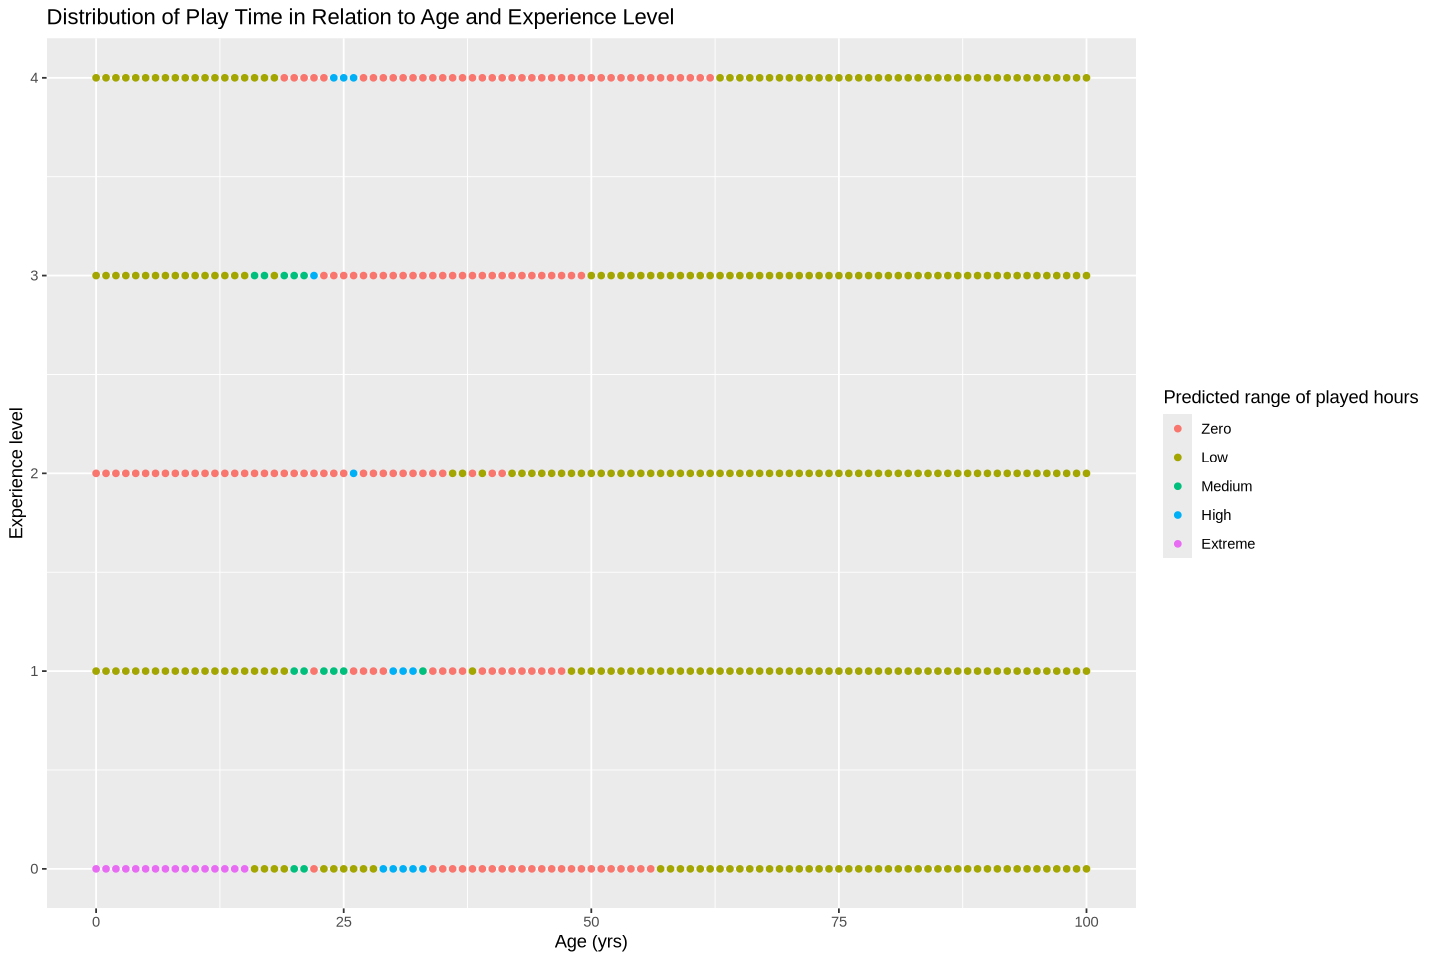

In [15]:
player_model_alternate <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
            set_engine("kknn") |>
            set_mode("classification")

player_fit_alternate <- workflow() |>
        add_recipe(player_recipe) |>
        add_model(player_model_alternate) |>
        fit(data = data_training)

predictions_alternate <- predict(player_fit_alternate, fake_players)|>
                bind_cols(fake_players)

options(repr.plot.width=12, repr.plot.height=8)
prediction_plot_alternate <- predictions_alternate |>
                ggplot(aes(x=age, y=exp_level, color = .pred_class)) +
                geom_point() +
                labs(x="Age (yrs)", y= "Experience level", color = "Predicted range of played hours", title = "Distribution of Play Time in Relation to Age and Experience Level")

prediction_plot_alternate

We see a much more detailed distribution of playtimes. We can also create a bar plot to display the counts of each predicted playtime class for the experience levels as well as the ages.

`summarise()` has grouped output by 'exp_level'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


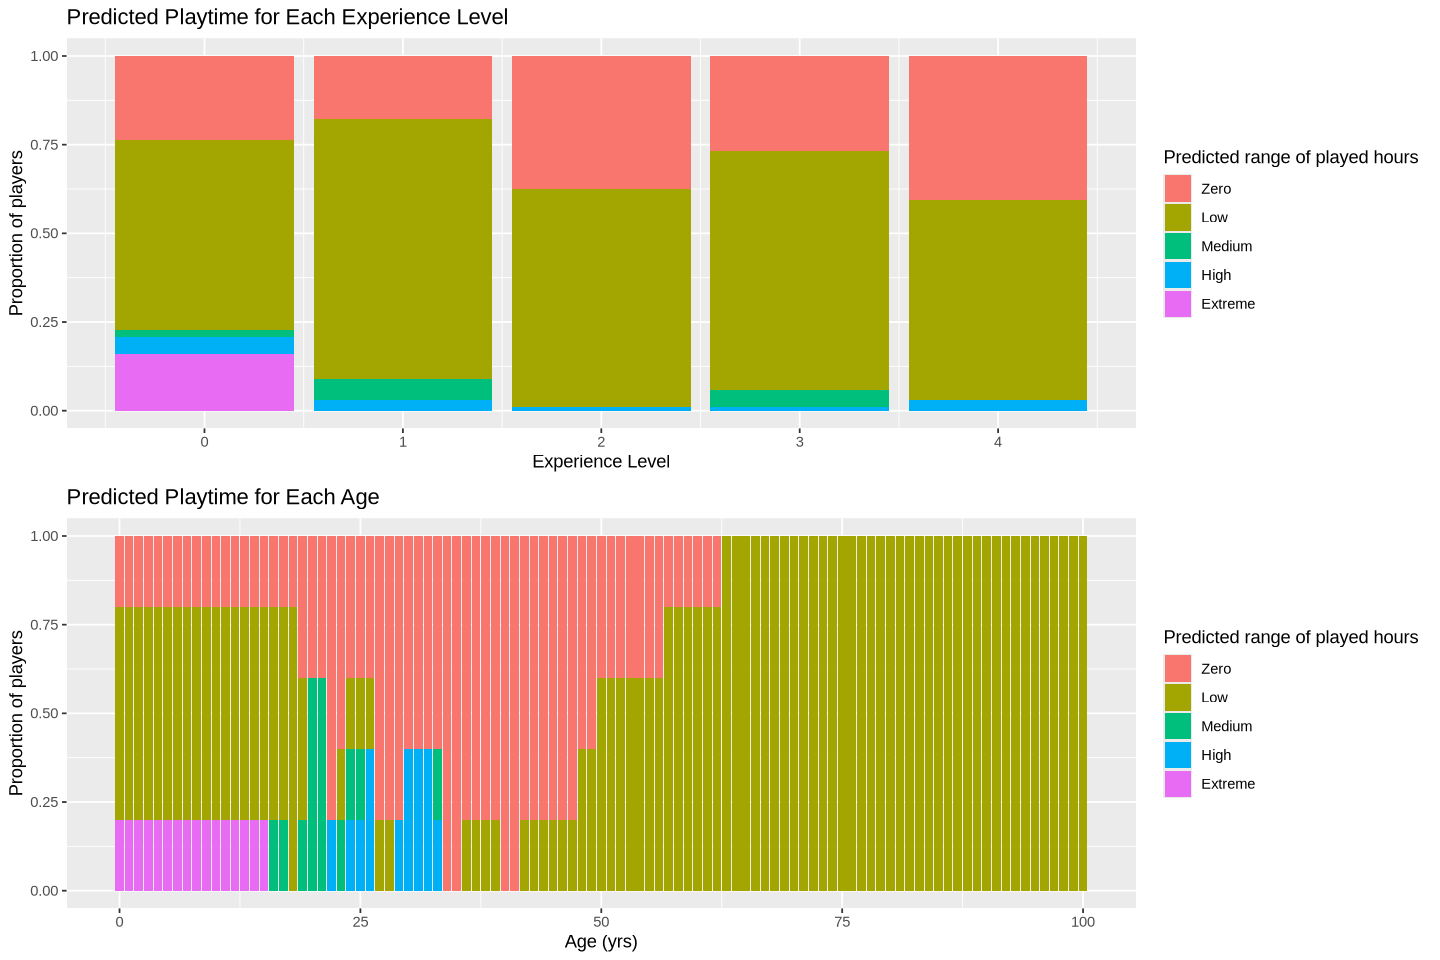

In [19]:

experience_counts <- predictions_alternate |>
            group_by(exp_level, .pred_class) |>
            summarize(number = n())

bar_experience <- experience_counts |>
                ggplot(aes(x=exp_level, y=number, fill = .pred_class)) +
                geom_bar(stat = "identity", position = "fill") +
                labs(x="Experience Level", y="Proportion of players", fill = "Predicted range of played hours", title = "Predicted Playtime for Each Experience Level")

age_counts <- predictions_alternate |>
            group_by(age, .pred_class) |>
            summarize(number = n())

bar_age <- age_counts |>
                ggplot(aes(x=age, y=number, fill = .pred_class)) +
                geom_bar(stat = "identity",position = "fill") +
                labs(x="Age (yrs)", y="Proportion of players", fill = "Predicted range of played hours", title = "Predicted Playtime for Each Age")

# View the plots side-by-side.
library(gridExtra)
grid.arrange(bar_experience, bar_age)

## **Discussion**

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

### **References**